In [18]:
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
import labtrinket
import serial
import time

# Objective

In this experiment you will use the photoresistor in a potential divider circuit. 
You will 
Optimize the circuit to give the most useful light sensitivity range.
Use the sensor to measure red, green and blue light.
Observe the wavelength effect
Observe the response time of the photoresistor

## Setup

For this lab you need:
Both mounted protoboards
- Both mounted protoboards
- 3 long jumper wires
- The trinket
- The photoresistor
- The book of resistors

Mount the trinket on the offset protoboard (the one which looks like a flag). Place it so that it is as far to the right hand edge as it will go with its USB overhanging.

On the other board set up the photoresistor (R2) and a $220\Omega$ resistor (R1) as a potential divider as shown. The photoresistor should be positioned so that it is as close as possible to the center of the board.

Connect the two boards with long jumper wires as shown. 
- The 3V output of the trinket -> free end of photoresistor.
- Gnd -> free end of resistor
- ADC input (pin 0) -> common point between the two resistors.

Mount both boards on the rail so that the onboard LED on the trinket is pointing directly at the photoresistor and fairly close, around 1cm.

![board setup](Lab1_bb.png "Breadboard setup")

![potential divider](photoresistor.png "Potential divider circuit")

Hopefully you can see here that we have set up the resistors as a potential divider. This is a very common configuration for resistive sensors such as the photoresistor. 

### Note about notebook keyboard shortcuts and text
In these tasks you have to insert code in various places as well as write some things. It is easy to add new cells for these: When the cell is in _command mode_ , meaning it has a blue bar on the left rather than green. You can press `B` to add a new cell below or `A` to add it above. Also if you execute a cell with `Alt+Enter`, a new blank cell is automatically created below the current cell after executing. `Ctrl+Enter` executes without creating a new cell. 

New cells default as code cells but you can change them to text cells (such as this one!) When the cell is in command mode you can press `M`, otherwise you can choose Markdown form the dropdown box on the toolbar. When editing a markdown cell you can just type text. You can use Latex equations in markdown cells by wrapping them in dollar signs. For example this: ```$y = A \omega^2 \sin{\theta}$``` produces:  $y = A \omega^2 \sin{\theta}$. Press `Ctrl+Enter` just like with a code cell to see the markdown cell rendered. Feel free to double click on some of my text cells in this notebook to see how I produced different effects like __bold__, _italic_ and `code`

## Task 1: Determining resistance range of photoresistor

First we will find out what range of resistances the photoresistor has in light and dark.

With a fixed resistor of 220$\Omega$ you will measure the maximum and minimum resistance. When you execute the cell below it should turn off the LED and gather 50 ADC values storing their average value in the variable `v1`. 
It is not essential to have absolute darkness but the background light should be as low as possible, either place the equipment in the box while running or else turn off the room lights. Make sure the background light conditions are the same each time you make a measurement.

Lets set up some variables right away. `r1` will be the resistance of the fixed resistor and `vcc` the supply voltage from the trinket.

In [2]:
r1 = 220
vcc = 3.3

Set up the serial connection. As usual change the COM port to match your system.

In [19]:
ser = serial.Serial()
ser.port = 'COM7'
ser.baudrate = 9600
ser.open()
trinket = labtrinket.LabTrinket(ser)

Test your serial connection by turning the LED on the trinket on and off. You should be able to do that using the previous instructions on setting up the trinket. Add a cell below this one to execute the commands

We will measure the voltage across the resistor in light and dark conditions. Below we'll define a function to take an average of a set of n measurements.

In [20]:
trinket.ledOn()

In [6]:
trinket.ledOff()

In [21]:
def averageVoltage(n):
    trinket.adcRun()
    v = 0
    i = 0
    while i<n:
        if trinket.adcGetValue():
            val = trinket.value
            v = v + val
           # print("{:}->{:}".format(i,val))
            i = i+1
    trinket.adcStop()
    return v / n

The lines below will turn off the LED, set the delay for the ADC so that a measurement is taken every 0.2 seconds. Switch to volt mode so  that the ADC values are returned as an actual voltage and finally it will take the average of 50 measurements and store the result in the variable vdark. Make sure your trinket is in darkness and then run this code.

In [22]:
trinket.ledOff()
trinket.adcDelay(0.2)
trinket.adcVoltMode(True)
vdark = averageVoltage(50)

You can insert a cell below this one (press B while this cell is highlighted in blue) in that cell use the ```vdark``` you just measured to calculate the resistance of the photoresistor $R_2$ in the dark. Remember, you are measuring the voltage across the *fixed* resistor (R1). That voltage should be given by:

$$V_1 = V_{cc}\frac{R_1}{R_1 + R_2} \qquad\text{Eq. 1}$$ 

Where $R_2$ is the resistance of the photoresistor. Store the calculated $R_2$ in a variable called `rdark`

Once you have rdark it's time to measure the light resistance the light resistance. turn the led on and set its color to 255,255,255 and brightness to 100. Then take another set of 50 measurements to get the vlight and rlight. Remember to keep your equipment covered or in the same ambient light as the dark measurements. Before running the average voltage function it is a good idea to clear the serial input buffer with the command `reset_input_buffer` otherwise unread values from the last run may still be in memory to contaminate your results.

In [24]:
trinket.ledOn()
trinket.ledSetColor(red=255,green=255,blue=255)
trinket.adcDelay(0.2)
trinket.adcVoltMode(True)


In [ ]:
vlight = averageVoltage(50)

In [8]:
ser.reset_input_buffer()

In [16]:
rlight = r1 *(vcc / vlight - 1)
rdark = r1 *(vcc / vdark - 1)

In [17]:
print (rlight)
print (rdark)

122.37618314315124
11100.648801040372


In [8]:
rlight = 122.37618314315124

In [9]:
rdark = 11100.648801040372

Print out your values for rlight and rdark

In [18]:
print("R light = {:},  R dark = {:}".format(rlight,rdark))

R light = 122.37618314315124,  R dark = 11100.648801040372


## Task 2: Maximize the sensor range

You will have seen that the between ```vlight``` and ```vdark``` did not correspond to the full range of voltages measureable by the ADC (0 to 3.3V)  This is not ideal. An ADC divides its range into individual steps so if we do not use all of it we are wasting the available resolution of the measurement. We would like to maximize the difference between the maximum and minimum voltages. This can be done be selecting the right resistor for the $R_1$ - 220$\Omega$  is not the optimum!

This is easily done. The light and dark voltages are both found using Eq.1 above, using the light and dark resistances in for r2. The range of voltages is just the difference between the two. 

Using Eq 1 you should be able to write down an equation for the voltage range in terms of $R_{dark}$, $R_{light}$ and $R_1$. Having done so you should be able to differentiate the equation with respect to $R_1$ and find the maximum. There is actually a nice simple equation to find the ideal resistance for $R_1$ when there are two extreme resistances for $R_2$. Do the calculus and the write down the equation in the markdown cell below. 

__Maximum voltage swing given by__: 

$$V = V_{cc}\Bigl(\frac{R_1}{R_1 + R_L} - \frac{R_1}{R_1 + R_D}\Bigl)$$ 

$$R_1 = \sqrt{R_LR_D}$$

In [12]:
R_1 = pow((rlight*rdark),0.5)

In [13]:
print(R_1)

1165.5277906098675


__Bonus__: try plotting yor voltage range function vs $R_1$ to see how this resistor affects output.

Having established the resistance to give you the widest range, select the nearest resistor value from the range available and use it to replace the 220$\Omega$ resistor. Store the value of the chosen resistor in the variable ```rsense```

In [14]:
rsense = 1200

## Task 3: Measuring photoresistor response
We will now get to the main part of the lab you will do a run of measurements to see how the photoresistor responds to light changes. First we create two arrays, one to hold our brightness values and the other to hold our measured voltages. 

In [9]:
brightness = np.linspace(0,100,101)
voltage = np.zeros(101)

The first creates an array of 101 numbers from 0 to 100. The second creates an array of 101 zeros. Now run your experiment as before with dark and maximum brightness, storing the voltages in `vlight2` and `vdark2` Print out those voltages. Remeber to run `reset_input_buffer` before each run.

The following code will run through the brightness levels setting the LED each time and recording the voltage. Note some things about this code:
* This time we are only averaging over 5 measurements otherwise it will take a long time! 
* The first line `for i,b in enumerate(brightness):` steps through the contents of the brightness array returning both the brightness value in `b` and the index `i` of each element. This `i` then used to assign the corresponding element of the voltage array.
* Note there is a delay provided by `sleep(1)` this makes the loop pause for 1 second. Photoresistors are slow to respond to light changes so this give it time to adjust before measuring.

In [10]:
trinket.ledSetColor(red=255,green=255,blue=255)
ser.reset_input_buffer()

In [11]:
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    time.sleep(1)
    voltage[i] = averageVoltage(5)
ser.reset_input_buffer()

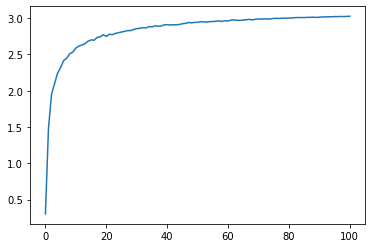

In [12]:
plt.plot(brightness,voltage)

Repeat your run 3 more times with the _color_ of the LED set to red, green and then blue. You can copy and paste the for loop code from above into 3 more cells and edit. Create 3 more zeroed arrays first to hold the red, green and blue voltage values. Name the arrays `voltageRed`, `voltageBule` and `voltageGreen`. Plot the runs all together with the code below.

In [13]:
voltageRed = np.zeros(101)
trinket.ledSetColor(red=255,green=0,blue=0)
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    time.sleep(1)
    voltageRed[i] = averageVoltage(5)
ser.reset_input_buffer()

In [14]:
voltageBlue = np.zeros(101)
trinket.ledSetColor(red=0,green=0,blue=255)
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    time.sleep(1)
    voltageBlue[i] = averageVoltage(5)
ser.reset_input_buffer()

In [15]:
voltageGreen = np.zeros(101)
trinket.ledSetColor(red=0,green=255,blue=0)
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    time.sleep(1)
    voltageGreen[i] = averageVoltage(5)
ser.reset_input_buffer()

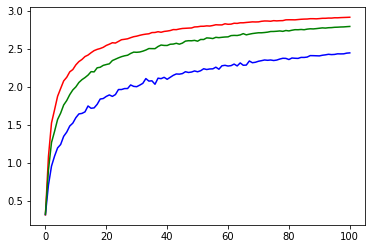

In [16]:
plt.plot(brightness,voltageRed,color = "red")
plt.plot(brightness,voltageBlue,color = "blue")
plt.plot(brightness,voltageGreen,color = "green")
plt.show()

Comment on the results. Are the relative voltages for the different colors as you would expect?

Since energy is inversely proportional to the wavelength and blue has a smaller wavelength, then the energy of a blue photon is more than that of a red photon. Having the same power, that means that there will be less photons of blue than the red. And the photo sensor measures the amount of photons. Red having higher voltage is what would be expected since the green wavelength falls between red and blue, with blue having the smallest wavelength. 

### Final observations

Before you finish try two more things. 
1. What is the effect of changing the value of the delay in the loop? What happens if you remove this altogether?


2. What is the effect of reducing the averaging? What if you only take one value per brightness level?




1a. Reducing the value of the delay.

In [27]:
voltage1 = np.zeros(101)
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    time.sleep(.1)
    voltage1[i] = averageVoltage(5)
ser.reset_input_buffer()

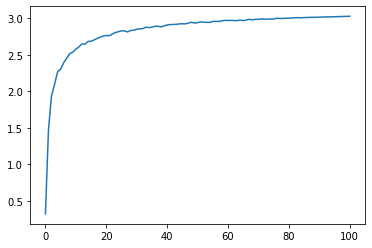

In [28]:
plt.plot(brightness,voltage1)

1b. Removing the delay

In [29]:
voltage2 = np.zeros(101)
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    voltage2[i] = averageVoltage(5)
ser.reset_input_buffer()

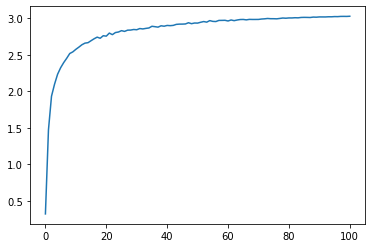

In [32]:
plt.plot(brightness,voltage2)


As mentioned above, photoresistors are slow to respond so the voltages will be taken immediately after changing the brightness so the voltages will be inacurate to what the photoresistor would register at that intensity. This will show a less smooth curve. 

2a. Reducing the averaging

In [34]:
voltage3 = np.zeros(101)
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    time.sleep(1)
    voltage3[i] = averageVoltage(2)
ser.reset_input_buffer()

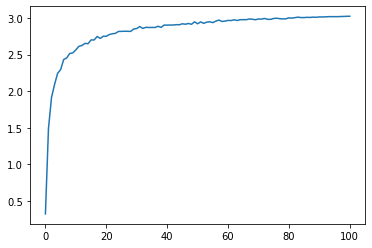

In [35]:
plt.plot(brightness,voltage3)

2b. Removing averaging and only taking one reading 

In [36]:
voltage4 = np.zeros(101)
for i,b in enumerate(brightness):
    ser.reset_input_buffer()
    trinket.ledSetBrightness(b)
    time.sleep(1)
    voltage4[i] = averageVoltage(1)
ser.reset_input_buffer()

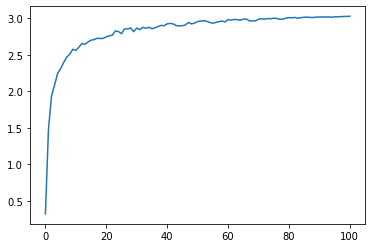

In [37]:
plt.plot(brightness,voltage4)

The data is more erratic and the curve of the output isn't as smooth.

Make sure to close the serial connection before diconnecting your trinket.

In [17]:
trinket.ledOff()
ser.close()
